# Group Chat

Group chat is a design pattern where a group of agents share a common thread
of messages: they all subscribe and publish to the same topic. 
Each participant agent is specialized for a particular task, 
such as writer, illustrator, and editor
in a collaborative writing task.
You can also include an agent to represent a human user to help guide the
agents when needed.

In a group chat, participants take turn to publish a message, and the process
is sequential -- only one agent is working at a time.
Under the hood, the order of turns is maintained by a Group Chat Manager agent,
which selects the next agent to speak upon receving a message.
The exact algorithm for selecting the next agent can vary based on your
application requirements. 
Typically, a round-robin algorithm or a selector with an LLM model is used.

Group chat is useful for dynamically decomposing a complex task into smaller ones 
that can be handled by specialized agents with well-defined roles.
It is also possible to nest group chats into a hierarchy with each participant
a recursive group chat.

In this example, we use AutoGen's Core API to implement the group chat pattern
using event-driven agents.
Please first read about [Topics and Subscriptions](../core-concepts/topic-and-subscription.md)
to understand the concepts and then [Messages and Communication](../framework/message-and-communication.ipynb)
to learn the API usage for pub-sub.
We will demonstrate a simple example of a group chat with a LLM-based selector
for the group chat manager, to create content for a children's story book.

```{note}
While this example illustrates the group chat mechanism,
the [AgentChat API](../../agentchat-user-guide/index.md) has a built-in implementation
of selector group chat. You can use that if you do not want to learn the Core API.
```

In [15]:
import json
import uuid
from typing import List

import openai
from autogen_core.application import SingleThreadedAgentRuntime
from autogen_core.base import MessageContext, TopicId
from autogen_core.components import (
    DefaultTopicId,
    FunctionCall,
    Image,
    RoutedAgent,
    TypeSubscription,
    message_handler,
)
from autogen_core.components.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    OpenAIChatCompletionClient,
    SystemMessage,
    UserMessage,
)
from autogen_core.components.tools import FunctionTool
from IPython.display import display # type: ignore
from pydantic import BaseModel

## Message Protocol

The message protocol for the group chat pattern is simple.
1. To start, user or an external agent publishes a `GroupChatMessage` message to the common topic of all participants.
2. The group chat manager selects the next speaker, sends out a `RequestToSpeak` message to that agent.
3. The agent publishes a `GroupChatMessage` message to the common topic upon receiving the `RequestToSpeak` message.
4. This process continues until a termination condition is reached at the group chat manager, which then stops issuing `RequestToSpeak` message, and the group chat ends.

In [16]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass

## Agents

Let's first define the agent class that only uses LLM models to generate text.
This is for the writer and editor.

In [17]:
class ChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.append(message.body)

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        completion = await self._model_client.create([self._system_message] + self._chat_history + [UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately", source="system")])
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )

Now let's define the `IllustratorAgent` which uses a DALL-E model to generate
an illustration based on the description provided.
We set up the image generator as a tool using {py:class}`~autogen_core.components.tools.FunctionTool`
wrapper, and use a model client to make the tool call.

In [18]:
class IllustratorAgent(RoutedAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._image_client = image_client
        self._system_message = SystemMessage(
            "You are an Illustrator. You use the generate_image tool to create images given user's requirement."
        )
        self._chat_history: List[LLMMessage] = []
        self._image_gen_tool = FunctionTool(
            self._image_gen,
            name="generate_image",
            description="Call this to generate an image given a text description.",
        )

    async def _image_gen(self, description: str) -> str:
        response = await self._image_client.images.generate(
            prompt=description.strip(), model="dall-e-2", response_format="b64_json", size="256x256"
        )
        return response.data[0].b64_json # type: ignore

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.append(message.body)

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history + [UserMessage(content=f"Transfered to {self.id.type}, adopt the persona immediately.", source="system")], 
            tools=[self._image_gen_tool], 
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            print(arguments["description"], flush=True)
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

Lastly, we define the `GroupChatManager` agent which manages the group chat
and selects the next agent to speak using an LLM.
The group chat manager checks if the editor has approved the draft by 
looking for the `"APPORVED"` keyword in the message. If the editor has approved
the draft, the group chat manager stops selecting the next speaker, and the group chat ends.

The group chat manager's constructor takes a list of participants' topic types
as an argument.
To prompt the next speaker to work, 
the it publishes a `RequestToSpeak` message to the next participant's topic.

In this example, we also make sure the group chat manager always picks a different
participant to speak next, by keeping track of the previous speaker.
This helps to ensure the group chat is not dominated by a single participant.

In [19]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type : str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the editor, stop the chat.
        if message.body.source == "Editor":
            assert isinstance(message.body.content, str)
            if "APPROVE" in message.body.content.upper():
                return
        # Format message history.
        messages : List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line : List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            selector_prompt.format(
                roles=roles,
                history=history,
                participants=str([topic_type for topic_type in self._participant_topic_types if topic_type != self._previous_participant_topic_type]),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")

## Creating the Group Chat

To set up the group chat, we create an {py:class}`~autogen_core.application.SingleThreadedAgentRuntime`
and register the agents' factories and subscriptions.

Each participant agent subscribes to both the group chat topic as well as its own
topic in order to receive `RequestToSpeak` messages, 
while the group chat manager agent only subcribes to the group chat topic.

In [20]:
runtime = SingleThreadedAgentRuntime()

editor_topic_type = "Editor"
writer_topic_type = "Writer"
illustrator_topic_type = "Illustrator"
group_chat_topic_type = "group_chat"

editor_description = "Editor for providing feedbacks and approving drafts."
writer_description = "Writer for creating any text content."
illustrator_description = "An illustrator for creating images."

editor_agent_type = await ChatAgent.register(
    runtime,
    editor_topic_type,  # Using topic type as the agent type.
    lambda: ChatAgent(
        description=editor_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-mini",
            # api_key="YOUR_API_KEY",
        ),
        system_message="You are an Editor. Provide critical feedbacks to the draft and illustration. "
        "Reply 'APPROVE' if you approve the draft and illustration.",
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=editor_topic_type, agent_type=editor_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=editor_agent_type.type))

writer_agent_type = await ChatAgent.register(
    runtime,
    writer_topic_type,  # Using topic type as the agent type.
    lambda: ChatAgent(
        description=writer_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-mini",
            # api_key="YOUR_API_KEY",
        ),
        system_message="You are a Writer. You produce good work.",
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=writer_topic_type, agent_type=writer_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=writer_agent_type.type))

illustrator_agent_type = await IllustratorAgent.register(
    runtime,
    illustrator_topic_type,
    lambda: IllustratorAgent(
        description=illustrator_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-mini",
            # api_key="YOUR_API_KEY",
        ),
        image_client=openai.AsyncClient(
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=illustrator_topic_type, agent_type=illustrator_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=illustrator_agent_type.type)
)

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[writer_topic_type, illustrator_topic_type, editor_topic_type],
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-mini",
            # api_key="YOUR_API_KEY",
        ),
        participant_descriptions=[writer_description, illustrator_description, editor_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)

## Running the Group Chat

We start the runtime and publish a `GroupChatMessage` for the task to start the group chat.


--------------------------------------------------------------------------------
Writer:
**Title: The Friendly Dragon**

In a valley lush where wildflowers grow,  
Lived a dragon named Fern, with a gentle glow.  
Her scales shone bright in the warm sunlight,  
With a laugh like a breeze, she brought pure delight.  

She danced on the hills with a fluttering grace,  
Her heart full of kindness, a smile on her face.  
Children would gather to sing and to play,  
With Fern the kind dragon, they'd laugh and they'd sway.  

She'd share stories of old 'neath the starlit sky,  
While the moon whispered secrets, low and nearby.  
"Fear not," she'd say, "for I'm here to befriend,  
In my heart lies a warmth that will never end."  

So if you wander where the wildflowers bloom,  
And hear the soft hum of a friendly tune,  
Know Fern's watching over, with love in her heart,  
A dragon so gentle, a true work of art.  

---

*Illustration Idea:* Imagine a vibrant scene depicting Fern the dragon—a 

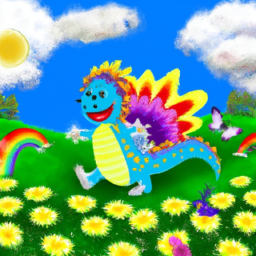


--------------------------------------------------------------------------------
Editor:
The poem you've created is delightful, capturing the essence of a friendly dragon beautifully. The imagery is vivid and invites readers into a magical world. The rhythmic flow and playful language are appealing for children.

The illustration complements the poem well, featuring a colorful dragon that embodies the friendly spirit described. The bright colors and joyful scene effectively convey a sense of happiness and whimsy.

Overall, I’d say both the poem and illustration work together harmoniously. 

**APPROVE**


In [21]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(content="Please write a short poem about a friendly dragon with illustration.", source="User")
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()

From the output, you can see the writer, illustrator, and editor agents
taking turns to speak and collaborate to generate a poem with an illustration.

## Next Steps

This example showcases a simple implementation of the group chat pattern -- it is not meant to be used
in real applications. You can make the following improvements:

* Termination condition: use the group chat manager to decide whether the task is completed
* Add user agent: add a human participant to the group chat so the group chat manager can escalate to the human if the task is not progressing.
* Better speaker selection: you can avoid using LLM when simple rules are sufficient and more reliable. For example, you can use a rule that the editor always speaks after the writer.

The [AgentChat API](../../agentchat-user-guide/index.md) provides a high-level
API for selector group chat. It has more features but mostly shares the same
design as this implementation.